# 사전 학습된 CNN(VGG-16)을 이용한 Fine Tunig
## VGG-16 Model
* University of Oxford - Visual Geometry Group
* 2014 ILSVRC 2nd Model
* ImageNet Large Scale Visual Recognition Challenge (ILSVRC)


In [ ]:
import warnings
warnings.filterwarnings('ignore')

* Import TensorFlow

In [ ]:
import tensorflow as tf

tf.__version__

'2.11.0'

# I. wget From Github
* 'dogs_and_cats_small.zip' 파일 다운로드

In [ ]:
!wget https://raw.githubusercontent.com/rusita-ai/pyData/master/dogs_and_cats_small.zip

--2023-03-25 02:07:09--  https://raw.githubusercontent.com/rusita-ai/pyData/master/dogs_and_cats_small.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90618980 (86M) [application/zip]
Saving to: ‘dogs_and_cats_small.zip’

dogs_and_cats_small 100%[===================>]  86.42M   175MB/s    in 0.5s    

2023-03-25 02:07:14 (175 MB/s) - ‘dogs_and_cats_small.zip’ saved [90618980/90618980]



* 다운로드 결과 확인

In [ ]:
!ls -l 

total 88500
-rw-r--r-- 1 root root 90618980 Mar 25 02:07 dogs_and_cats_small.zip
drwxr-xr-x 1 root root     4096 Mar 23 18:57 sample_data


# II. Data Preprocessing

> ## 1) Unzip 'dogs_and_cats_small.zip'

In [ ]:
!unzip -q /content/dogs_and_cats_small.zip

* 학습 데이터 확인

In [ ]:
!ls -l

total 88512
-rw-r--r-- 1 root root 90618980 Mar 25 02:07 dogs_and_cats_small.zip
drwxr-xr-x 1 root root     4096 Mar 23 18:57 sample_data
drwxr-xr-x 4 root root     4096 Mar 25 02:07 test
drwxr-xr-x 4 root root     4096 Mar 25 02:07 train
drwxr-xr-x 4 root root     4096 Mar 25 02:07 validation


> ## 2) Image_File Directory Setting

* train_dir
* valid_dir
* test_dir

In [ ]:
train_dir = 'train'
valid_dir = 'validation'
test_dir = 'test'

# III. Data Preprocessing

> ## 1) ImageDataGenerator( ) & flow_from_directory( )

* Normalization
 * ImageDataGenerator( )
* Resizing & Generator
 * flow_from_directory( )

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# With Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   brightness_range = [0.5, 1.5],
                                   fill_mode = 'nearest')

# Without Augmentation 
valid_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  target_size = (150, 150),
                  batch_size = 20,
                  class_mode = 'binary')

valid_generator = valid_datagen.flow_from_directory(
                  valid_dir,
                  target_size = (150, 150),
                  batch_size = 20,
                  class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# IV. Import VGG-16 Model & Some Layers Freezing

> ## 1) conv_base

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (150, 150, 3))

58889256/58889256 [==============================] - 2s 0us/step


> ## 2) Model Information

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

> ## 3) 'block5_conv<font color = 'red'>*</font>' Freezing

> ### (1) Before 'weight' Freezing

In [ ]:
print('conv_base 동결 전 훈련 가능 가중치의 종류:', len(conv_base.trainable_weights))

conv_base 동결 전 훈련 가능 가중치의 종류: 26


* Model Weights Information

In [ ]:
conv_base.get_weights()

[array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
           -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
          [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
           -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
          [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
           -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],
 
         [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
           -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
          [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
           -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
          [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
           -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],
 
         [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
           -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
          [-8.13870355e-02,  4.18543853e-02, -1.01763301e-01, ...,
           -9.431

* Model Layers Information

In [ ]:
conv_base.layers

* Layer[-4]'s Name

In [ ]:
conv_base.layers[-4].name

'block5_conv1'

* Layer[-4]'s Weights

In [ ]:
conv_base.layers[-4].weights

[<tf.Variable 'block5_conv1/kernel:0' shape=(3, 3, 512, 512) dtype=float32, numpy=
 array([[[[-6.0689339e-04,  1.4231558e-03,  7.3316055e-03, ...,
            2.6178278e-03,  4.3357504e-04, -2.9434897e-03],
          [-4.8605306e-03,  4.9075234e-04, -1.2511463e-03, ...,
            1.1560039e-03, -1.2683710e-04, -1.5934335e-02],
          [ 8.2136225e-03,  7.4967248e-03,  4.4443067e-03, ...,
           -1.0573096e-02, -1.3803735e-02, -2.0028956e-03],
          ...,
          [ 2.0234480e-03, -5.8380342e-03, -2.3825851e-03, ...,
            1.3192679e-03, -8.6920448e-03, -8.2156417e-04],
          [ 7.9414165e-03, -8.0086980e-03,  7.7348115e-04, ...,
            9.1014095e-03,  6.8836473e-04, -9.8630879e-03],
          [ 7.3094536e-03, -1.1607672e-03,  5.1686643e-03, ...,
           -1.8046533e-03, -7.7111748e-05,  3.5778836e-03]],
 
         [[-1.5249068e-03, -3.1574788e-03,  4.5571220e-03, ...,
           -8.1634670e-03, -8.1500728e-03, -5.8323247e-03],
          [-1.2195857e-03, -5.4

> ### (2) <font color = 'blue'>weight' Freezing

In [ ]:
for layer in conv_base.layers[:-4]:
    layer.trainable = False

> ### (3) After 'weight' Freezing

In [ ]:
print('conv_base 동결 후 훈련 가능 가중치의 종류:', len(conv_base.trainable_weights))

conv_base 동결 후 훈련 가능 가중치의 종류: 6


* Model Information

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

# V. Keras CNN Modeling with VGG-16 Freezed Layers

> ## 1) Model Define

* 'conv_base' & 'Classification' Network
* Dropout Layer

In [ ]:
from tensorflow.keras import models, layers

model = models.Sequential(name = 'CNN_VGG16')
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model.summary()

Model: "CNN_VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


> ## 2) Model Compile

* 모델 학습방법 설정
 * 이미 학습된 Weight 값을 Tuning
 * <font color = 'red'>매우 작은 Learnig Rate 지정</font>
 * optimizers.Adam(learning_rate = 0.000005)

In [ ]:
from tensorflow.keras import optimizers

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(learning_rate = 0.000005),
              metrics = ['accuracy'])

> ## 3) Model Fit

* 약 15분

In [ ]:
%%time

Hist_dandc = model.fit(train_generator,
                       steps_per_epoch = 100,
                       epochs = 30,
                       validation_data = valid_generator,
                       validation_steps = 50)

Epoch 1/30
100/100 [==============================] - 43s 284ms/step - loss: 0.7258 - accuracy: 0.5350 - val_loss: 0.6303 - val_accuracy: 0.6630
Epoch 2/30
100/100 [==============================] - 29s 294ms/step - loss: 0.6582 - accuracy: 0.6040 - val_loss: 0.5695 - val_accuracy: 0.6990
Epoch 3/30
100/100 [==============================] - 29s 290ms/step - loss: 0.6214 - accuracy: 0.6525 - val_loss: 0.4880 - val_accuracy: 0.7670
Epoch 4/30
100/100 [==============================] - 29s 292ms/step - loss: 0.5692 - accuracy: 0.7055 - val_loss: 0.4242 - val_accuracy: 0.8090
Epoch 5/30
100/100 [==============================] - 28s 283ms/step - loss: 0.5195 - accuracy: 0.7430 - val_loss: 0.3819 - val_accuracy: 0.8300
Epoch 6/30
100/100 [==============================] - 28s 283ms/step - loss: 0.5022 - accuracy: 0.7585 - val_loss: 0.3515 - val_accuracy: 0.8380
Epoch 7/30
100/100 [==============================] - 29s 294ms/step - loss: 0.4505 - accuracy: 0.7780 - val_loss: 0.3320 - val_ac

> ## 4) 학습 결과 시각화

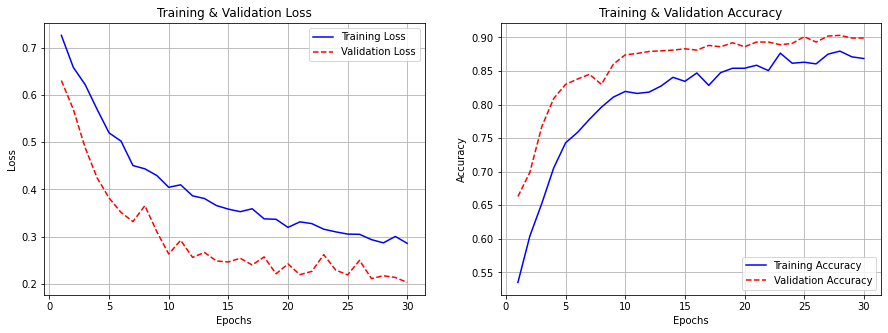

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, Hist_dandc.history['loss'], 'b-')
plt.plot(epochs, Hist_dandc.history['val_loss'], 'r--')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, Hist_dandc.history['accuracy'], 'b-')
plt.plot(epochs, Hist_dandc.history['val_accuracy'], 'r--')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()

plt.show()

> ## 5) Model Evaluate

* test_generator

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
                 test_dir,
                 target_size = (150, 150),
                 batch_size = 20,
                 class_mode = 'binary')

Found 1000 images belonging to 2 classes.


* Loss & Accuracy

In [ ]:
loss, accuracy = model.evaluate(test_generator,
                                steps = 50, 
                                verbose = 0)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

Loss = 0.23321
Accuracy = 0.90800


# 
# 
# 
# The End
# 
# 
# 